In [17]:
%load_ext autoreload
%autoreload 2
from openseespy.opensees import *
#from OpenSeesPymoo.FRP_jacket import opensees_configure
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

import vfo.vfo as vfo

#from pymoo.core.problem import ElementwiseProblem
#from pymoo.algorithms.moo.nsga2 import NSGA2
#from pymoo.operators.crossover.sbx import SBX
#from pymoo.operators.mutation.pm import PM
#from pymoo.operators.sampling.rnd import FloatRandomSampling
#from pymoo.termination import get_termination
#from pymoo.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of vfo.vfo failed: Traceback (most recent call last):
  File "c:\Users\intm2\gpt\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\intm2\gpt\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "C:\Python39\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 790, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\intm2\gpt\lib\site-packages\vfo\vfo.py", line 29, in <module>
    pv.set_jupyter_backend('panel')
  File "c:\Users\intm2\gpt\lib\site-packages\pyvista\jupyter\__init__.py", line 113, in set_jupyter_backend
    pyvista.global_theme._jupyter_backend = _validate_jupyter_backend(backend)
  File "c:\Users\intm2\gpt\lib\site-pack

In [14]:
## Test
wipe()


# Create ModelBuilder (with two-dimensions and 3 DOF/node)
model('basic', '-ndm', 2, '-ndf', 3)

# Set parameters for overall model geometry
CRB = 0.5
CRC = 0.7

nStory = 3
nSpan = 3

Height = 3000
Span = 6000

EffectiveDepth = 6000/1.0

# Loads calc
DL = 5.0*1000/1000000
LL = 2.4*1000/1000000

tmp = 1.0*(DL+0.25*LL)
beamload = (-1)*(DL+0.25*LL)*(1000)
unitWeight = np.ones((3,1))*(DL)
ShearPoint = np.zeros((6,4))
nColumnMaterial = (nStory)*(nSpan+1)
nColumn = (nStory)*(nSpan+1)
Ast = np.zeros((nColumnMaterial,1))
Eccu = np.zeros(((nStory)*(nSpan+1),1))

g = 9806.65

# Pushover control
IDctrlNode = 41
IDctrlDOF = 1
nStep = 500
Dmax = Height*nStory*0.04*1.0
Dincr = Dmax/nStep


# In[6]:


######################################################
######################################################
######################################################
######################################################
#####################For end user#####################
######################################################
######################################################
######################################################
######################################################
# set objective values
nVar = 6
nObj = 2
nCon = 12+1

x = [8,7,0,8,8,1];
y = np.zeros((1,nObj))
cons = np.zeros((1,nCon))
######################################################
######################################################
######################################################
######################################################
######################################################
######################################################
######################################################
######################################################
tf = 0.33
AcceptanceCriteria = [0.01, 0.02, 0.04]
CB1 = 300
CH1 = 300
CB2 = 400
CH2 = 400

unitVolume1 = (2*CB1+2*CH1)*(CH1)*tf
unitVolume2 = (2*CB2+2*CH2)*(CH2)*tf

unitVolume3 = (2*CB1+2*CH1)*Height*tf
unitVolume4 = (2*CB2+2*CH2)*Height*tf

FRPlimit = [3,3,2,1,1,1]

y[0] = 0;
for i in range(1,nVar+1):
    if i < 4:
        y[0] = y[0] + unitVolume1*x[i-1]*2
    else:
        y[0] = y[0] + unitVolume2*x[i-1]*2
    
    
    if x[i-1] >= FRPlimit[i-1]:
        if i < 4:
            y[0] = y[0] + ( unitVolume3 - unitVolume1 ) *2
        else:
            y[0] = y[0] + ( unitVolume4 - unitVolume2 ) *2
        
Individual = np.zeros((2*nVar,1))
for i in range(1,nVar+1):
    if i <= nStory:
        Individual[i-1][0] = x[i-1]
        Individual[i+nStory-1][0] = x[i-1]
    else:
        Individual[i+1*nStory-1][0] = x[i-1]
        Individual[i+2*nStory-1][0] = x[i-1]
    

for i in range(1,nVar*2+1):
    if Individual[i-1][0] == 1:
        Individual[i-1][0] = 0

nFRP = Individual


# In[7]:


# Fiber definition
# Steel fiber
fy = 300.0
Es = 200000

hardeningratio = 0.03

RebarSpacings = 25.0
ShearSpacings = 300

# Concrete fiber
BSec1 = 300
HSec1 = 300

BSec2 = 400
HSec2 = 400

BSec3 = 250
HSec3 = 500

A1 = HSec1*BSec1
A2 = HSec2*BSec2
A3 = HSec3*BSec3

I1 = CRC*HSec1*HSec1*HSec1*BSec1/12.0
I2 = CRC*HSec2*HSec2*HSec2*BSec2/12.0
I3 = CRB*HSec3*HSec3*HSec3*BSec3/12.0

D10 = 9.53
A10 = 71.3

D19 = 19.1
A19 = 286.5

D22 = 22.2 
A22 = 387.1

fc = 21.0
Ec = 4700*math.sqrt(fc)    
eps1 = 2*fc/Ec
eps2 = 0.0035

# Fiber section
numP = 6;
numBarsSec11 = 4
numBarsSec12 = 2
numBarsSec13 = 2
numBarsSec14 = 4

numBarsSec21 = 5
numBarsSec22 = 2
numBarsSec23 = 2
numBarsSec24 = 2
numBarsSec25 = 5

numBarsSec31 = 3
numBarsSec32 = 2

numBarsSec41 = 3
numBarsSec42 = 2
numBarsSec43 = 2

cover = 40
coverY1 = HSec1/2.0
coverZ1 = BSec1/2.0
coreY1 = coverY1 - cover - D10 - D19/2
coreZ1 = coverZ1 - cover - D10 - D19/2

coverY2 = HSec2/2.0
coverZ2 = BSec2/2.0
coreY2 = coverY2 - cover - D10 - D22/2
coreZ2 = coverZ2 - cover - D10 - D22/2

coverY3 = HSec3/2.0
coverZ3 = BSec3/2.0
coreY3 = coverY3 - cover - D10 - D19/2
coreZ3 = coverZ3 - cover - D10 - D19/2

nfY = 20
nfZ = 20


# In[8]:


# Create nodes
for i in range(1,nStory+2):
    for j in range(1,nSpan+2):
        
        node(i*10 + j, Span*(j-1), Height*(i-1) );

for j in range(1,nSpan+2):
    i = 1
    fix(i*10 + j, 1, 1, 1)        
    
for i in range(2,nStory+2):
    for j in range(2,nSpan+2):
        equalDOF(i*10 + 1, i*10+j, 1)


# In[9]:


# mass
StoryTotalWeight = unitWeight*(nSpan*Span)*EffectiveDepth
SpanWeight = StoryTotalWeight/nSpan
TotalWeight = sum(StoryTotalWeight)

for i in range(2,nStory+2):
    for j in range(1,nSpan+2):
        
        if j==1 or j==nSpan+1:
            mass(i*10 + j, SpanWeight[i-2][0]/g/2,0,0)  
        else:
            mass(i*10 + j, SpanWeight[i-2][0]/g,0,0) 


# In[10]:


# Shear definition (assumed very large for reinforced ones)
G = 0.4*Ec
Kshearspring01 = (5/6)*BSec1*HSec1*G/Height
Kshearspring02 = (5/6)*BSec2*HSec2*G/Height
BigNumber = 10000000000
nColumn = (nStory)*(nSpan+1)
Vn = BigNumber

for i in range(1,7):
    
    if i <= 3:
        j = i
        ShearPoint[i-1][0] = Vn
        ShearPoint[i-1][1] = Vn/Kshearspring01/HSec1
        ShearPoint[i-1][2] = Vn*0.3
        ShearPoint[i-1][3] = Vn/Kshearspring01/HSec1*10
    else:
        j=i+6
        ShearPoint[i-1][0]= Vn
        ShearPoint[i-1][1] = Vn/Kshearspring02/HSec2
        ShearPoint[i-1][2] = Vn*0.3
        ShearPoint[i-1][3] = Vn/Kshearspring02/HSec2*10
        
    uniaxialMaterial('Hysteretic', 500+i, ShearPoint[i-1][0], ShearPoint[i-1][1], ShearPoint[i-1][2], ShearPoint[i-1][3], (-1)*ShearPoint[i-1][0], (-1)*ShearPoint[i-1][1], (-1)*ShearPoint[i-1][2], (-1)*ShearPoint[i-1][3], 0, 0, 0, 0)


# In[11]:


# FRP Effects on existing materials 
uniaxialMaterial('Steel01',1,fy,Es,hardeningratio)
uniaxialMaterial('Concrete01',2,-fc,-eps1,-fc,-eps2)

for i in range(1,nColumnMaterial+1):
    
    niFRP = nFRP[i-1][0]
#     if i<=(2*nStory):
#         Ast = ( numBarsSec11 + numBarsSec12 + numBarsSec13 + numBarsSec14 ) * A19
#     else:        
            
    if nFRP[i-1][0] < 0.1:
        uniaxialMaterial('Concrete01',100+i, fc*(-1), eps1*(-1), fc*(-1), eps2*(-1))
        Eccu[i-1][0] = eps2
    else:
        if (i<=nStory*2):
            # Concrete info
            Ast = ( numBarsSec11 + numBarsSec12 + numBarsSec13 + numBarsSec14 ) * A19
            b = BSec1
            h = HSec1
            rc = 25
            tf = 0.33
            efu_ = 0.0167
            Ef = 227527
            n = niFRP
            Ce = 0.95
            Ke = 0.55
            Pf = 0.95
            ec = eps1
            Ag = h*b
            rhog = Ast/Ag
            D = math.sqrt(b**2 + h**2)
            AreaRatio = (1- ( (b/h)*((h-2*rc)**2) + (h/b)*((b-2*rc)**2) )/(3*Ag) - rhog) / (1-rhog)
            Ka = AreaRatio*((b/h)**2)
            Kb = AreaRatio*((h/b)**0.5)
            efu = Ce*efu_
            efe = Ke*efu
            
            if efe > 0.004:
                efe = 0.004

            fl = (2*Ef*n*tf*efe) / D
            Min_n = 0.08*fc/(2*Ef*tf*efe)*D
            Ec = 4700*math.sqrt(fc)
            eccu = ec * (1.5 + 12*Kb*(fl/fc)*((efe/ec)**0.45))
                         
            if eccu >= 0.01:
                eccu = 0.01
                         
            fcc = fc + Pf*3.3*Ka*fl
            E2 = (fcc-fc)/eccu
            et = (2*fc)/(Ec-E2)
            tmpfc = fc + E2*et
            tmpet = et
            tmpfcc = fcc
            tmpeccu = eccu
            uniaxialMaterial('Concrete01',100+i, (-1)*tmpfc, (-1)*tmpet, (-1)*tmpfcc, (-1)*tmpeccu )
        else:
            # Concrete info
            Ast = ( numBarsSec21 + numBarsSec22 + numBarsSec23 + numBarsSec24 + numBarsSec25 ) * A22
            b = BSec2
            h = HSec2
            rc = 25            
            tf = 0.33
            efu_ = 0.0167
            Ef = 227527
            n = niFRP
            Ce = 0.95
            Ke = 0.55
            Pf = 0.95
            ec = eps1
            Ag = h*b
            rhog = Ast/Ag
            D = math.sqrt(b**2 + h**2)
            AreaRatio = (1- ( (b/h)*((h-2*rc)**2) + (h/b)*((b-2*rc)**2) )/(3*Ag) - rhog) / (1-rhog)
            Ka = AreaRatio*((b/h)**2)
            Kb = AreaRatio*((h/b)**0.5)
            efu = Ce*efu_
            efe = Ke*efu
            if efe > 0.004:
                efe = 0.004

            fl = (2*Ef*n*tf*efe) / D
            Min_n = 0.08*fc/(2*Ef*tf*efe)*D
            Ec = 4700*math.sqrt(fc)
            eccu = ec * (1.5 + 12*Kb*(fl/fc)*((efe/ec)**0.45))
            if eccu > 0.01:
                eccu = 0.01
            else:
                eccu = eccu
                         
            fcc = fc + Pf*3.3*Ka*fl
            E2 = (fcc-fc)/eccu
            et = (2*fc)/(Ec-E2)
            tmpfc = fc + E2*et
            tmpet = et
            tmpfcc = fcc
            tmpeccu = eccu
            uniaxialMaterial('Concrete01',100+i, (-1)*tmpfc, (-1)*tmpet, (-1)*tmpfcc, (-1)*tmpeccu )
        
        Eccu[i-1][0] = tmpeccu


# In[12]:


# Insert fiber
nColumnSection = (nStory)*(nSpan+1)
tmp1 = (nStory*2)

for i in range(1,nColumnSection+1):
    if i <= tmp1:
        Ccover = cover + D10 + D19/2
        section('Fiber',i)
        patch('quad',100+i,nfZ,nfY,-HSec1/2, BSec1/2, -HSec1/2, -BSec1/2,HSec1/2, -BSec1/2,HSec1/2, BSec1/2)
        layer('straight', 1, numBarsSec11, A19, HSec1/2-Ccover,       BSec1/2-Ccover, HSec1/2-Ccover,       -(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec12, A19, (HSec1/2-Ccover)*1/3, BSec1/2-Ccover, (HSec1/2-Ccover)*1/3, -(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec13, A19, -(HSec1/2-Ccover)*1/3,BSec1/2-Ccover, -(HSec1/2-Ccover)*1/3,-(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec14, A19, -(HSec1/2-Ccover),    BSec1/2-Ccover, -(HSec1/2-Ccover),    -(BSec1/2-Ccover))        
    else:
        Ccover = cover + D10 + D22/2
        section('Fiber',i)
        patch('quad',100+i,nfZ,nfY,-HSec2/2, BSec2/2, -HSec2/2, -BSec2/2,HSec2/2, -BSec2/2,HSec2/2, BSec2/2)
        layer('straight', 1, numBarsSec21, A22, HSec1/2-Ccover,       BSec1/2-Ccover, HSec1/2-Ccover,       -(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec22, A22, (HSec1/2-Ccover)*1/2, BSec1/2-Ccover, (HSec1/2-Ccover)*1/2, -(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec23, A22, 0,       BSec1/2-Ccover, 0,       -(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec24, A22, -(HSec1/2-Ccover)*1/2,BSec1/2-Ccover, -(HSec1/2-Ccover)*1/2,-(BSec1/2-Ccover))
        layer('straight', 1, numBarsSec25, A22, -(HSec1/2-Ccover),    BSec1/2-Ccover, -(HSec1/2-Ccover),    -(BSec1/2-Ccover))        


# In[13]:


ExtShearSpringData = [1,2,3,1,2,3]
IntShearSpringData = [6,4,5]
for i in range(1,nColumnSection+1):
    
    if i <= 6:
        #section('Aggregator',100+i, 500+ExtShearSpringData[i-1],'Vy','-section', i)
        section('Aggregator',100+i, 501,'Vy','-section', i)
    else:
        j= (i % 3)+1
        #section('Aggregator',100+i, 500+IntShearSpringData[j-1],'Vy','-section', i)
        section('Aggregator',100+i, 501,'Vy','-section', i)

section('Fiber',53)
patch('quad', 2,nfZ,nfY,-coverY3, coverZ3, -coverY3, -coverZ3, coverY3, -coverZ3, coverY3, coverZ3)
layer('straight', 1,numBarsSec31,A19, coreY3, coreZ3,  coreY3, -coreZ3)
layer('straight', 1,numBarsSec32,A19,-coreY3, coreZ3, -coreY3, -coreZ3)

section('Fiber', 54)
patch('quad', 2, nfZ, nfY, -coverY3, coverZ3, -coverY3, -coverZ3, coverY3, -coverZ3, coverY3, coverZ3)
layer('straight', 1, numBarsSec41, A19,  coreY3,coreZ3,  coreY3, -coreZ3)
layer('straight', 1, numBarsSec42, A19,  coreY3-25-D19,  coreZ3, coreY3-25-D19, -coreZ3)
layer('straight', 1, numBarsSec43, A19, -coreY3, coreZ3, -coreY3, -coreZ3)


# In[14]:


# Defining beam with hinges
nColumn = (nStory)*(nSpan+1)
geomTransf('Linear',2)
geomTransf('PDelta',1)
##section('Fiber',501)
section('Elastic',990501,Ec,A1,I1)
##section('Fiber',502)
section('Elastic',990502,Ec,A2,I2)
section('Elastic',990503,Ec,A3,I3)

for i in range(1,nColumn+1):
    iStory = (i % nStory)
    if iStory == 0:
        iStory = 3
        
    iSpan = math.floor( (i-1)/nStory )
    
    if i <= nStory:
        #element('beamWithHinges',i,10*iStory+1,10*(iStory+1)+1,100+i,HSec1*0.5,100+i,HSec1*0.5,Ec,A1,I1, 1)
        beamIntegration('HingeRadau',10000+i, 100+i,HSec1*0.5,100+i,HSec1*0.5,990501)
        element('forceBeamColumn',i,10*iStory+1,10*(iStory+1)+1, 1,10000+i)
    elif i <= (2*nStory):
        #element('beamWithHinges', i, 10*iStory+(nSpan+1), 10*(iStory+1)+(nSpan+1), 100+i, HSec1*0.5, 100+i, HSec1*0.5,Ec,A1,I1,1)
        beamIntegration('HingeRadau',10000+i, 100+i,HSec1*0.5,100+i,HSec1*0.5,990501)
        element('forceBeamColumn',i,10*iStory+(nSpan+1), 10*(iStory+1)+(nSpan+1), 1,10000+i)
    else:
        #element('beamWithHinges', i, 10*iStory+iSpan, 10*(iStory+1)+iSpan, 100+i,HSec2*0.5, 100+i, HSec2*0.5,Ec,A2,I2,1)
        beamIntegration('HingeRadau',10000+i, 100+i,HSec1*0.5,100+i,HSec1*0.5,990502)
        element('forceBeamColumn',i,10*iStory+iSpan, 10*(iStory+1)+iSpan, 1,10000+i)     


# In[15]:


# Manual definition
beamIntegration('HingeRadau',10000+13, 53, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',13,21,22,2,10000+13)
beamIntegration('HingeRadau',10000+14, 54, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',14,22,23,2,10000+14)
beamIntegration('HingeRadau',10000+15, 54, HSec3*0.5,53,HSec3*0.5,990503)
element('forceBeamColumn',15,23,24,2,10000+15)

beamIntegration('HingeRadau',10000+16, 53, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',16,31,32,2,10000+16)
beamIntegration('HingeRadau',10000+17, 54, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',17,32,33,2,10000+17)
beamIntegration('HingeRadau',10000+18, 54, HSec3*0.5,53,HSec3*0.5,990503)
element('forceBeamColumn',18,33,34,2,10000+18)

beamIntegration('HingeRadau',10000+19, 53, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',19,41,42,2,10000+19)
beamIntegration('HingeRadau',10000+20, 54, HSec3*0.5,54,HSec3*0.5,990503)
element('forceBeamColumn',20,42,43,2,10000+20)
beamIntegration('HingeRadau',10000+21, 54, HSec3*0.5,53,HSec3*0.5,990503)
element('forceBeamColumn',21,43,44,2,10000+21)


# In[16]:


# Analysis
timeSeries("Linear",2)
pattern('Plain',1,2)
eleLoad('-ele', 13, 14, 15, '-type', '-beamUniform', beamload)
eleLoad('-ele', 16, 17, 18, '-type', '-beamUniform', beamload)
eleLoad('-ele', 19, 20, 21, '-type', '-beamUniform', beamload)

#DisplayModel2D NodeNumbers
#DisplayModel2D DeformedShape $ViewScale ;	# display deformed shape, the scaling factor needs to be adjusted for each model


system('BandGeneral')
constraints('Plain')
numberer('RCM')
test('EnergyIncr', 1.0e-8, 50)
algorithm('Newton')
integrator('LoadControl', 0.1, 5, 0.1, 0.1)
analysis('Static')
analyze(10)

print("Gravity load analysis completed")

loadConst('-time', 0.0)

pattern('Plain',3,2)
load(21, 0.167, 0.0, 0.0)
load(31, 0.333, 0.0, 0.0)
load(41, 0.5, 0.0, 0.0)

#recorder('Drift', '-file', "EQDrift.out", '-time', '-iNode', 11, 21, 31, '-jNode', 21, 31, 41, '-dof', 1, '-perDirn', 2)
recorder('Node', '-file', "node.out", '-time', '-node', 41, '-dof', 1, 'disp')
recorder('Node', '-file', "Vbase.out", '-node', 11, 12, 13, 14, '-dof', 1, 'reaction')

recorder('Element', '-file', "ColumnEleSection6force.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'section',  6, 'force')
recorder('Element', '-file', "ColumnEleSection6Deformation.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'section', 6, 'deformation')
recorder('Element', '-file', "ColumnEleSection1force.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'section',  1, 'force')
recorder('Element', '-file', "ColumnEleSection1Deformation.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'section',  1, 'deformation')

recorder('Element', '-file', "BeamEleSection6force.out", '-time', '-ele', 13, 14, 15, 16, 17, 18, 19, 20, 21, 'section',  6, 'force')
recorder('Element', '-file', "BeamEleSection6Deformation.out", '-time', '-ele', 13, 14, 15, 16, 17, 18, 19, 20, 21, 'section',  6, 'deformation')
recorder('Element', '-file', "BeamEleSection1force.out", '-time', '-ele', 13, 14, 15, 16, 17, 18, 19, 20, 21, 'section',  1, 'force')
recorder('Element', '-file', "BeamEleSection1Deformation.out", '-time', '-ele', 13, 14, 15, 16, 17, 18, 19, 20, 21, 'section',  1, 'deformation')

recorder('Element','-file', "EleLocalforce.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'localForce')

recorder('Element', '-file', "Strain1.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 'section', 1, 'fiber',coverY1, 0, 'stressStrain')
recorder('Element', '-file', "Strain2.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 'section', 1, 'fiber', -coverY1, 0, 'stressStrain')
recorder('Element', '-file', "Strain3.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 'section', np, 'fiber', coverY1, 0, 'stressStrain')
recorder('Element', '-file', "Strain4.out", '-time', '-ele', 1, 2, 3, 4, 5, 6, 'section', np, 'fiber', -coverY1, 0, 'stressStrain')

recorder('Element', '-file', "Strain5.out", '-time', '-ele', 7, 8, 9, 10, 11, 12, 'section', 1, 'fiber', coverY2, 0, 'stressStrain')
recorder('Element', '-file', "Strain6.out", '-time', '-ele', 7, 8, 9, 10, 11, 12, 'section', 1, 'fiber', -coverY2, 0, 'stressStrain')
recorder('Element', '-file', "Strain7.out", '-time', '-ele', 7, 8, 9, 10, 11, 12, 'section', numP, 'fiber', coverY2, 0, 'stressStrain')
recorder('Element', '-file', "Strain8.out", '-time', '-ele', 7, 8, 9, 10, 11, 12, 'section', numP, 'fiber', -coverY2, 0, 'stressStrain')


## constraintsType = Plain;      # default; 
# constraints('Plain')
# numberer('RCM')
## system Umfpack
# system('BandGeneral') 

Tol = 1.e-6        # Convergence Test: tolerance 
maxNumIter = 20      # Convergence Test: maximum number of iterations that will be performed before "failure to converge" is returned 
printFlag  = 0      # Convergence Test: flag used to print information on convergence (optional)        # 1: print information on each step; 
#set TestType NormDispIncr;   # Convergence-test type 
test('NormDispIncr', Tol, maxNumIter, printFlag) 

#set algorithmType Newton 
#set algorithm KrylovNewton
algorithm('Newton')

Dincr_min  = Dincr*1.0
Dincr_max  = Dincr*1.0
Jd = 4

integrator('DisplacementControl', IDctrlNode,IDctrlDOF,Dincr,Jd,Dincr_min,Dincr_max)
analysis('Static')

#  ---------------------------------    perform Static Pushover Analysis 
Nsteps = int(Dmax/Dincr)        # number of pushover analysis steps 
ok = analyze(Nsteps)                # this will return zero if no convergence problems were encountered 

if ok != 0:      
   # if analysis fails, we try some other stuff, performance is slower inside this loop 
    ok  = 0     
    controlDisp = 0.0
    D0 = 0.0      # analysis starts from zero
    Dstep = (controlDisp-D0)/(Dmax-D0) 

    while Dstep < 1.0 and ok == 0:    
      
        controlDisp = nodeDisp(IDctrlNode,IDctrlDOF) 
        Dstep = (controlDisp-D0)/(Dmax-D0) 
        ok = analyze(1) 
        if ok != 0: 
            print("Trying Newton with Initial Tangent ..") 
            test('NormDispIncr',Tol, 2000,  0) 
            algorithm('Newton','-initial') 
            ok = analyze(1) 
            test('NormDispIncr',Tol,maxNumIter,  0) 
            algorithm('Newton') 
       
        if ok != 0: 
            print("Trying Broyden ..") 
            algorithm('Broyden', 8) 
            ok = analyze(1) 
            algorithm('Newton') 
      
        if ok != 0: 
            print("Trying NewtonWithLineSearch ..") 
            algorithm('NewtonLineSearch', .8) 
            ok = analyze(1) 
            algorithm('Newton') 

print("Pushover analysis completed!!!")

Gravity load analysis completed
Pushover analysis completed!!!


No Model_ODB specified, trying to get data from the active model.


c:\Users\intm2\gpt\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


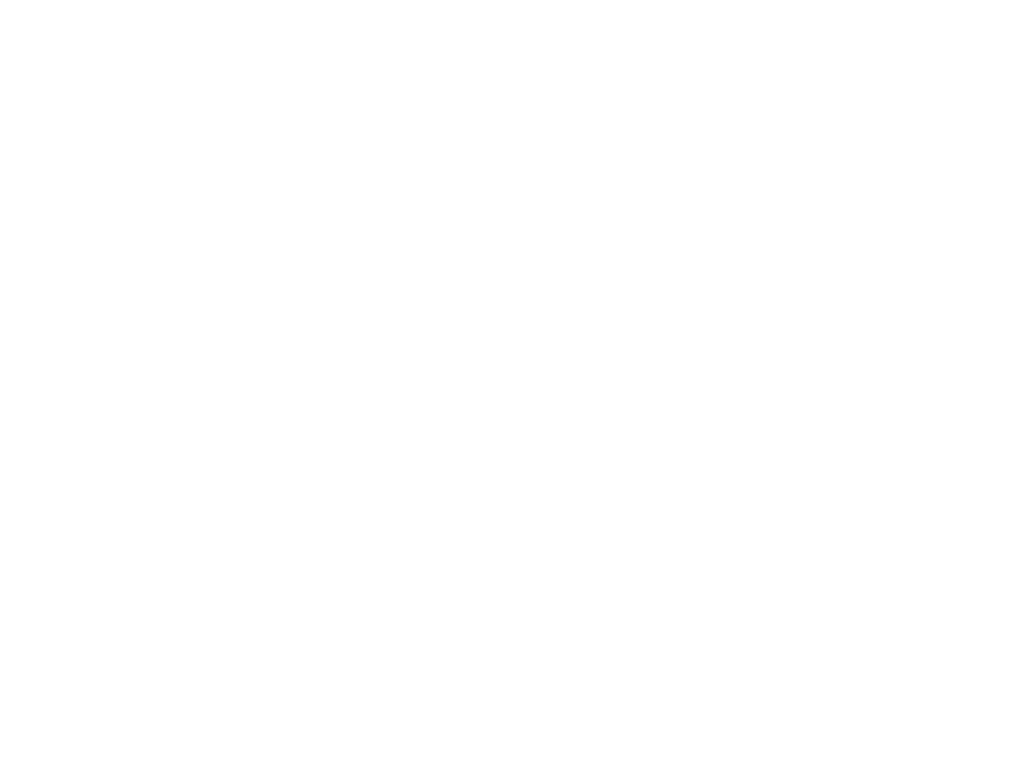

c:\Users\intm2\gpt\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


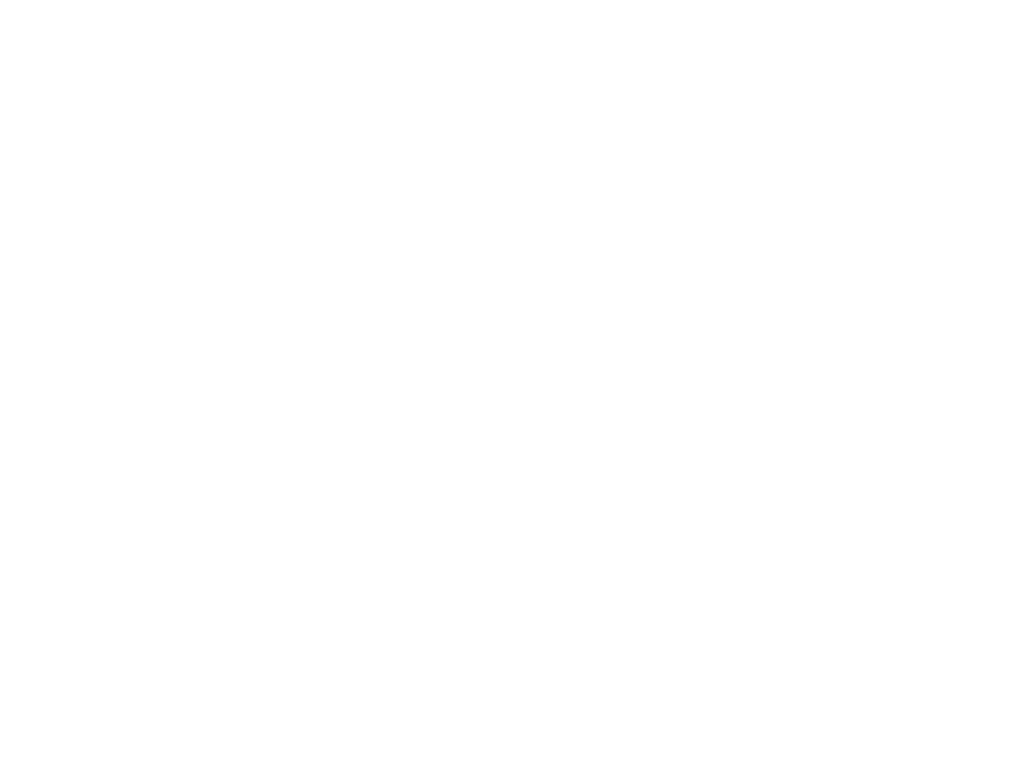

In [15]:
vfo.plot_model()